In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import re

In [3]:
# Load dataset
ahs_data = pd.read_csv('/Users/cattepper/Documents/ML in ECON/ahs2023n.csv')
ahs_data.head(100)

,CONTROL,TOTROOMS,PERPOVLVL,JACPRIMARY,JACSECNDRY,JADEQUACY,JAIRRATE,JBATHEXCLU,JBATHROOMS,JBEDROOMS,...,JOBFUNDS23,JOBFUNDS24,JOBTYPE21,JOBTYPE22,JOBTYPE23,JOBTYPE24,JOBWORKYR21,JOBWORKYR22,JOBWORKYR23,JOBWORKYR24
0,'11000002',6,-6,'0','0','2','0','0','0','0',...,' ',' ',' ',' ',' ',' ',' ',' ',' ',' '
1,'11000003',4,199,'0','0','2','0','0','0','0',...,' ',' ',' ',' ',' ',' ',' ',' ',' ',' '
2,'11000005',7,501,'0','0','2','0','0','0','0',...,' ',' ',' ',' ',' ',' ',' ',' ',' ',' '
3,'11000006',5,232,'0','0','2','0','0','0','0',...,' ',' ',' ',' ',' ',' ',' ',' ',' ',' '
4,'11000008',3,231,'2','2','2','0','0','0','0',...,' ',' ',' ',' ',' ',' ',' ',' ',' ',' '
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,'11000213',2,1,'0','0','2','0','0','0','0',...,' ',' ',' ',' ',' ',' ',' ',' ',' ',' '
96,'11000214',5,74,'0','0','2','0','0','0','0',...,' ',' ',' ',' ',' ',' ',' ',' ',' ',' '
97,'11000215',3,54,'0','0','2','0','0','0','0',...,' ',' ',' ',' ',' ',' ',' ',' ',' ',' '
98,'11000216',5,501,'0','0','2','0','0','0','0',...,' ',' ',' ',' ',' ',' ',' ',' ',' ',' '


In [4]:
for col in ahs_data.columns:
    if ahs_data[col].dtype == 'object':
        ahs_data[col] = ahs_data[col].str.replace("'", "", regex=False)
        ahs_data[col] = ahs_data[col].replace(['', ' ', '  ', '.'], np.nan)
        ahs_data[col] = ahs_data[col].str.strip()
        ahs_data[col] = ahs_data[col].replace('', np.nan)

numeric_cols = [col for col in ahs_data.columns if any(x in col for x in 
                ['JOB', 'FUNDS', 'TYPE', 'WORKYR', 'BEDROOMS', 'BATHROOMS'])]

for col in numeric_cols:
    ahs_data[col] = pd.to_numeric(ahs_data[col], errors='coerce')
print("\nMissing Values per Column:")
print(ahs_data.isnull().sum().sort_values(ascending=False).head(20))


Missing Values per Column:
JOBDIY24        55668
JOBFUNDS24      55668
JOBCOMP24       55668
JOBCOMPYR24     55668
JJOBTYPE24      55668
JJOBWORKYR24    55668
JJOBDIY24       55668
JJOBFUNDS24     55668
SSP14           55668
SECPARENT14     55668
SEMP14          55668
SEMP15          55668
SPOUSE14        55668
SPOUSE15        55668
SSIP14          55668
SSIP15          55668
SSP15           55668
PAP14           55668
PAP15           55668
PLINE14         55668
dtype: int64


In [5]:
# Keep columns with at least 50% non-null
threshold = len(ahs_data) * .5
print(ahs_data.shape)
ahs_data = ahs_data.loc[:, ahs_data.isnull().sum() <= threshold]
print(ahs_data.shape)

(55669, 3214)
(55669, 1392)


In [6]:
# Finds the Market Value Column
candidates = [c for c in ahs_data.columns if re.search(r'price|value|val|sale|market|home|worth', c, re.I)]
print(candidates)
ahs_data[candidates].head()

['JFIRSTHOME', 'JHHPRNTHOME', 'JHMRSALE', 'JMARKETVAL', 'JRMHOME', 'RMHOME', 'HMRSALE', 'HHPRNTHOME', 'FIRSTHOME', 'MARKETVAL']


,JFIRSTHOME,JHHPRNTHOME,JHMRSALE,JMARKETVAL,JRMHOME,RMHOME,HMRSALE,HHPRNTHOME,FIRSTHOME,MARKETVAL
0,0,0,0,0,0,-6,-6,-6,-6,-6
1,0,0,0,0,0,1,-6,1,-6,-6
2,0,0,0,0,0,-6,2,2,2,245790
3,0,0,0,0,0,-6,2,1,2,158200
4,0,0,0,0,0,-6,-6,2,-6,-6


In [7]:
# Drops rows with -6 in Market Value Column
ahs_data = ahs_data[ahs_data["MARKETVAL"] != -6]
ahs_data.shape

(32234, 1392)

In [8]:
# Gets rid of rows with more then 5 missing values
ahs_data = ahs_data[ahs_data.isnull().sum(axis=1) <= 5]
ahs_data.shape

(21357, 1392)

In [9]:
# Seperates the MarketVal column from the rest of the data
market_data = ahs_data["MARKETVAL"]
ahs_data = ahs_data.drop(columns=['MARKETVAL'])

In [10]:
# Combine MARKETVAL back temporarily for summary stats
summary_df = ahs_data.copy()
summary_df["MARKETVAL"] = market_data

summary_stats = summary_df.describe().T
summary_stats["median"] = summary_df.median(numeric_only=True)

# Reorder columns for readability
summary_stats = summary_stats[
    ["count", "mean", "median", "std", "min", "max"]
]

print(summary_stats)


              count           mean    median            std     min        max
TOTROOMS    21357.0       6.667229       7.0       1.564287     1.0       14.0
PERPOVLVL   21357.0     378.741490     461.0     149.014779     1.0      501.0
JBATHROOMS  21357.0       0.003278       0.0       0.084855     0.0        3.0
JBEDROOMS   21357.0       0.002154       0.0       0.065599     0.0        2.0
JCOOKTYPE   21357.0       0.001732       0.0       0.058440     0.0        2.0
...             ...            ...       ...            ...     ...        ...
HINCP       21357.0  155317.406003  110700.0  177503.501505     0.0  3480000.0
FINCP       21357.0  151105.649202  106500.0  175316.080967     0.0  3480000.0
REMODAMT    21357.0   11080.275601    1000.0   29055.267183     0.0   739270.0
TOTHCAMT    21357.0    2202.086997    1655.0    2941.578405     0.0    98220.0
MARKETVAL   21357.0  564652.740179  413417.0  668681.570483  1000.0  9999998.0

[567 rows x 6 columns]


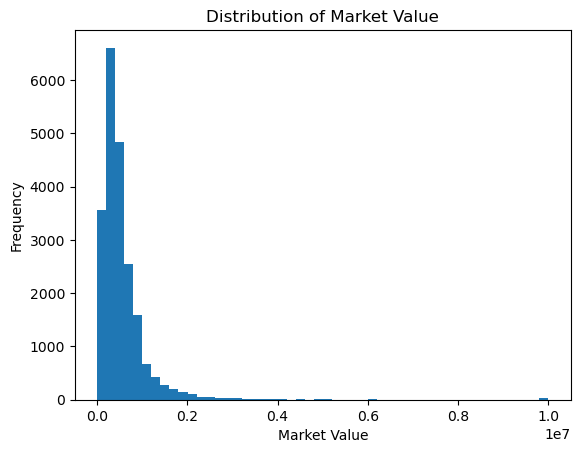

In [11]:
#Histogram of MARKETVAL
plt.figure()
plt.hist(market_data, bins=50)
plt.xlabel("Market Value")
plt.ylabel("Frequency")
plt.title("Distribution of Market Value")
plt.show()

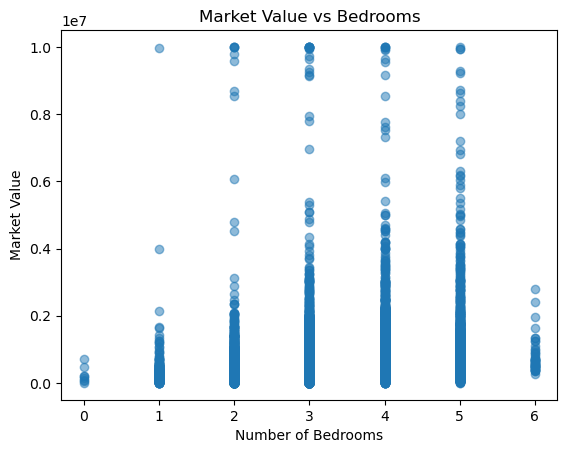

In [12]:
#Scatterplot of BEDROOMS vs MARKETVAL
plt.figure()
plt.scatter(ahs_data["BEDROOMS"], market_data, alpha=0.5)
plt.xlabel("Number of Bedrooms")
plt.ylabel("Market Value")
plt.title("Market Value vs Bedrooms")
plt.show()

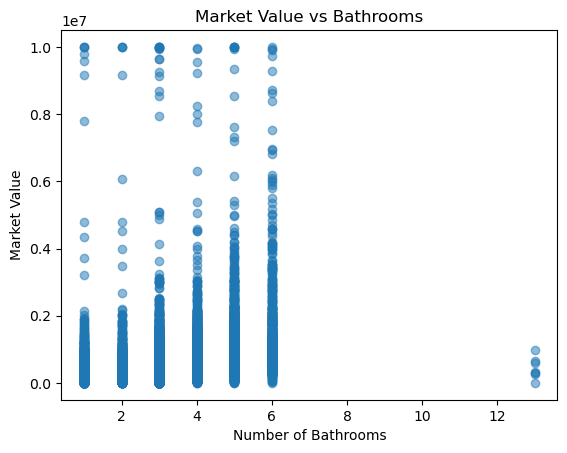

In [13]:
#Scatterplot of BATHROOMS vs MARKETVAL
plt.figure()
plt.scatter(ahs_data["BATHROOMS"], market_data, alpha=0.5)
plt.xlabel("Number of Bathrooms")
plt.ylabel("Market Value")
plt.title("Market Value vs Bathrooms")
plt.show()